#**Predictive Maintenance** : **Data Analysis & Time-Series Forecasting**


In [ ]:
#Importing Libraries and defining functions for plotting the data using **matplotlib**
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

matplotlib.style.use("Solarize_Light2")

%matplotlib inline

In [ ]:
#Reading_Data
Data_Dir = "/content/drive/MyDrive/Maintance_prediction"

telemetry_df = pd.read_csv("/content/drive/MyDrive/Maintance_prediction/dataset/PdM_telemetry.csv")
errors_df = pd.read_csv("/content/drive/MyDrive/Maintance_prediction/dataset/PdM_errors.csv")
maint_df = pd.read_csv("/content/drive/MyDrive/Maintance_prediction/dataset/PdM_maint.csv")
failure_df = pd.read_csv("/content/drive/MyDrive/Maintance_prediction/dataset/PdM_failures.csv")
machines_df = pd.read_csv("/content/drive/MyDrive/Maintance_prediction/dataset/PdM_machines.csv")

#Date and Time Formatting, Sorting based on Date for better readability
tables = [telemetry_df,errors_df,maint_df,failure_df]
for df in tables:
  df["datetime"] = pd.to_datetime(df["datetime"], format = "%Y-%m-%d %H:%M:%S")
  df.sort_values(["datetime","machineID"],inplace=True, ignore_index = True)

In [ ]:
failure_df.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,16,comp1
1,2015-01-02 03:00:00,16,comp3
2,2015-01-02 03:00:00,17,comp4
3,2015-01-02 03:00:00,22,comp1
4,2015-01-02 03:00:00,35,comp1


**Telemetry Data**




In [ ]:
#First few rows of Telemetry data for Machine 1
telemetry_df[telemetry_df.machineID==1].head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
100,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
200,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
300,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
400,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [ ]:
#Machine Count
telemetry_df.machineID.nunique()

100

In [ ]:
#Duration of the data
telemetry_df.datetime.describe(datetime_is_numeric=True)

count                 876100
mean     2015-07-02 18:00:00
min      2015-01-01 06:00:00
25%      2015-04-02 12:00:00
50%      2015-07-02 18:00:00
75%      2015-10-02 00:00:00
max      2016-01-01 06:00:00
Name: datetime, dtype: object

In [ ]:
#Duplictes Values


def check_duplicate(data_frame, columns_to_check):
    # Check if the input columns are valid
    for col in columns_to_check:
        if col not in data_frame.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")

    # Find duplicate rows based on the specified columns
    duplicate_rows = data_frame[data_frame.duplicated(subset=columns_to_check, keep=False)]

    return duplicate_rows

columns_to_check = ['datetime', 'machineID']
duplicate_rows = check_duplicate(telemetry_df, columns_to_check)
print("Duplicate Rows:")
print(duplicate_rows)
#check_duplicate(telemetry_df,['datetime', 'machineID'])


Duplicate Rows:
Empty DataFrame
Columns: [datetime, machineID, volt, rotate, pressure, vibration]
Index: []


In [ ]:
#Check Null Values

def check_null(data_frame):
    # Check for missing values in the DataFrame
    null_values = data_frame.isnull().sum()
    return null_values

null_values = check_null(telemetry_df)
print("Missing Values:")
print(null_values)

Missing Values:
datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64


In [ ]:
#Let's assume machineID as 10
print(f"Shape of the Telemetry Record: {telemetry_df.shape}")
df_sin = telemetry_df.loc[telemetry_df['machineID']==10].reset_index(drop=True)
df_sin.head(n=5)

Shape of the Telemetry Record: (876100, 6)


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,10,158.421261,500.830885,119.750673,45.571344
1,2015-01-01 07:00:00,10,174.631951,356.928821,88.860999,35.245965
2,2015-01-01 08:00:00,10,158.777566,467.162159,84.382394,37.975278
3,2015-01-01 09:00:00,10,178.128852,438.376292,105.870821,40.836263
4,2015-01-01 10:00:00,10,176.497316,364.918330,98.148214,35.511013


In [ ]:
#Failure record of Machine 10
sel_fail = failure_df.loc[failure_df['machineID']==10]
pd.DataFrame(sel_fail)

,datetime,machineID,failure
55,2015-01-19 06:00:00,10,comp2
219,2015-04-04 06:00:00,10,comp2
308,2015-05-19 06:00:00,10,comp2
338,2015-06-03 06:00:00,10,comp1
367,2015-06-18 06:00:00,10,comp2


In [ ]:
#Error Record of Machine 10
sel_err = errors_df.loc[errors_df['machineID']==10]
pd.DataFrame(sel_err).head()

,datetime,machineID,errorID
10,2015-01-01 20:00:00,10,error1
67,2015-01-06 04:00:00,10,error3
193,2015-01-18 06:00:00,10,error2
194,2015-01-18 06:00:00,10,error3
247,2015-01-22 05:00:00,10,error1


As per the Kaggle Dataset, error refers to non-breaking events while failure referes to event that cause the machine to fail.

So, using chronological plot we will define how error and failure relate with each other.

<ipython-input-15-dfe0aa14105e>:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plot_df.loc[:, 'timestamp'] = pd.to_datetime(plot_df.loc[:, 'timestamp'])


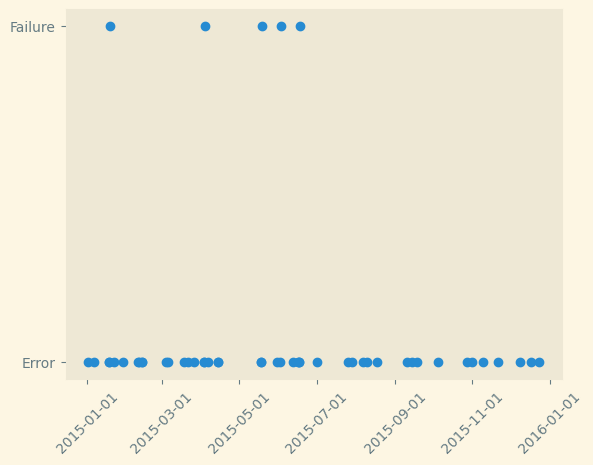

In [ ]:
fig, ax = plt.subplots()

#Using two values in the y-axis to make it simpler and differentiate between Error and Failure
y_category = list()

for iter in range(0, len(sel_fail)):
  y_category.append("Failure")

for iter in range(0, len(sel_err)):
  y_category.append("Error")

#Timestamp from error and selected failure
timestamp_df = pd.concat([sel_fail['datetime'],sel_err['datetime']], ignore_index=True, axis = 0)
plot_df = pd.DataFrame({'timestamp':timestamp_df,"category":y_category})
plot_df.loc[:, 'timestamp'] = pd.to_datetime(plot_df.loc[:, 'timestamp'])
plot_df.sort_values(by=['timestamp'],inplace = True, ignore_index=True)

# Plotting timestamp as per x-axis
ax.scatter('timestamp', 'category', data = plot_df)
year_fmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(year_fmt)
ax.tick_params(axis='x',rotation=45)
ax.grid()

From the above plot, we can see that failure are often times preceded by error in the machines. However, not all error results in immediate failure. Some times may passes before the failure in machine occurs.

So, we gotta be focusing on failure data and check which feature is effected by Machine Failure.

<ipython-input-16-aa754abdb8f6>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_sin.loc[:, 'datetime'] = pd.to_datetime(df_sin.loc[:, 'datetime']) #Changing Datatype of the timestamp column from object to datetime


Text(0, 0.5, 'Rotation')

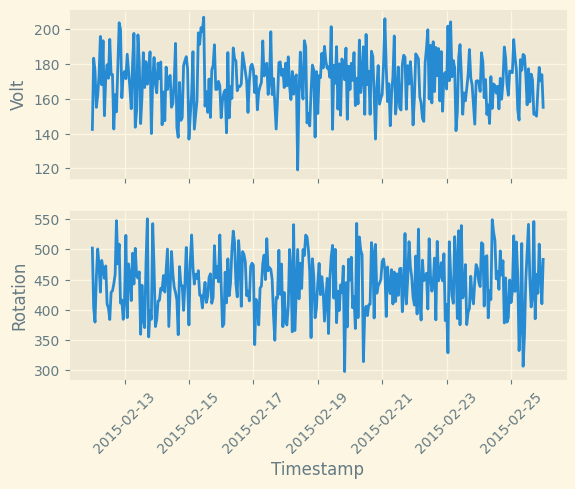

In [ ]:
#Feature Check
#Selecting Time Window from the failure record, then plotting each feature and checking there event of failures

df_sin.loc[:, 'datetime'] = pd.to_datetime(df_sin.loc[:, 'datetime']) #Changing Datatype of the timestamp column from object to datetime
st = df_sin.loc[df_sin['datetime']=="2015-02-19"].index.values[0] #Select the date to check from failure record

#Filtering the telemetry data by the date and allow 7 days before and after
#The error will occure to check any abnormalities
select = df_sin.loc[st-7*24:st + 7*24, :]

#Plot Volt and Rotation Feature
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot('datetime','volt', data=select)
ax[0].set_ylabel('Volt')

ax[1].plot('datetime','rotate',data=select)
ax[1].tick_params(axis='x',rotation = 45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Rotation")

As per the observation by above plots, there is no noticeable anamolies are shown around the period of 2015-02-19.

Now we will check both Pressure and Vibration features by Plotting them.

Text(0, 0.5, 'Vibrations')

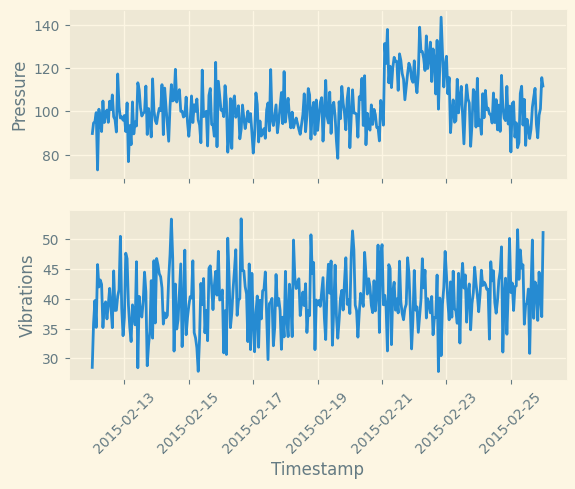

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot('datetime','pressure',data=select)
ax[0].set_ylabel('Pressure')

ax[1].plot('datetime','vibration',data=select)
ax[1].tick_params(axis='x',rotation = 45)
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Vibrations")

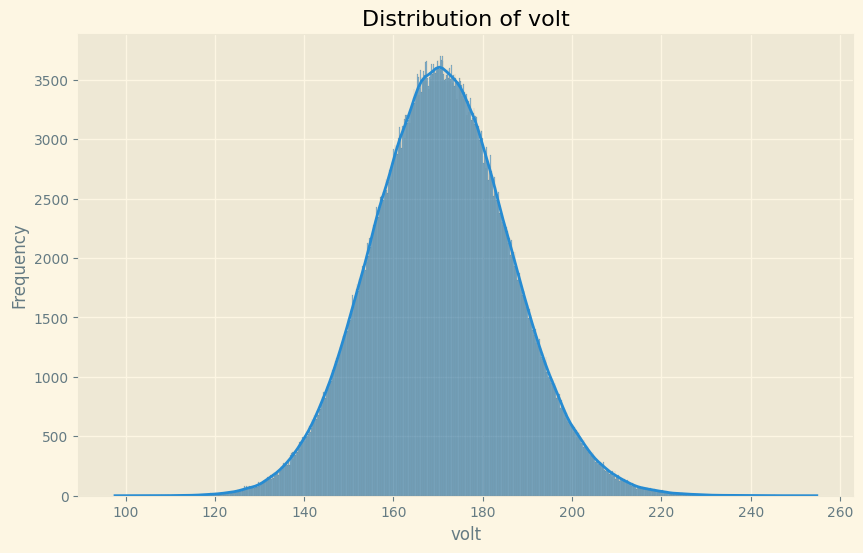

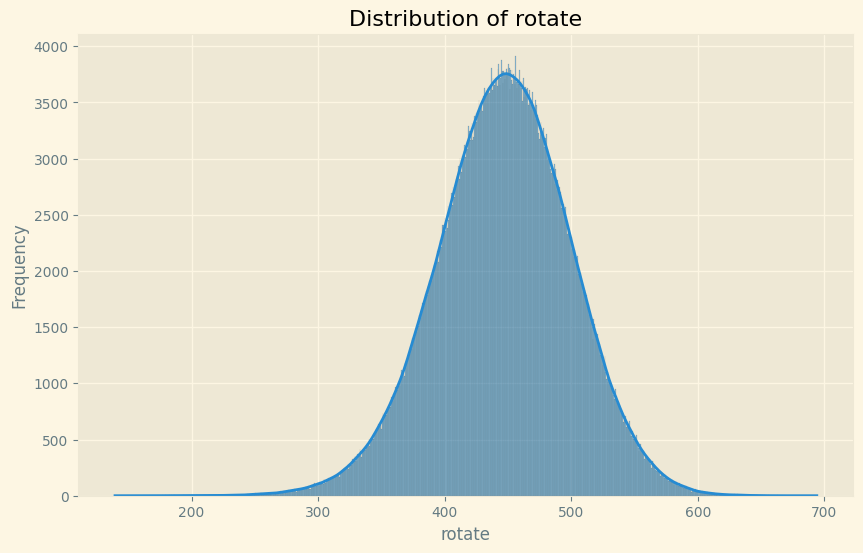

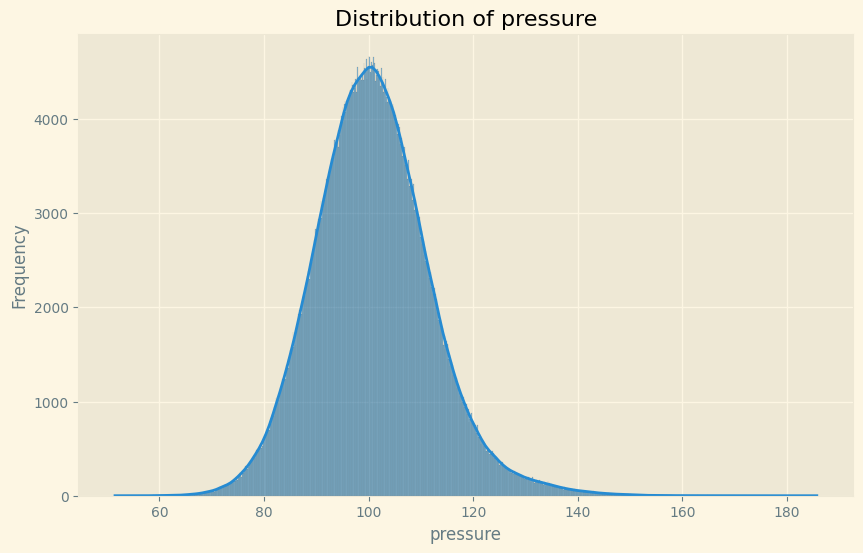

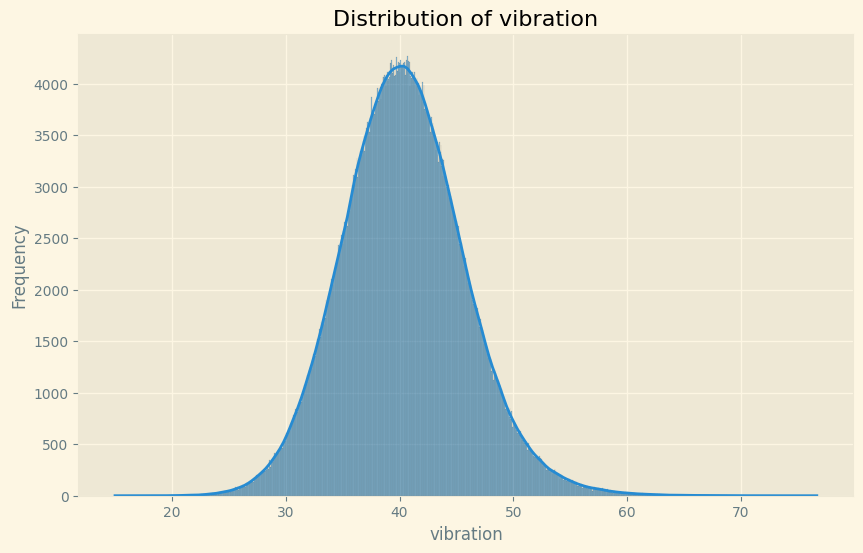

In [ ]:
#Plotting Distribution of Voltage, Rotate, Pressure, and Vibrations

import matplotlib.pyplot as plt
import seaborn as sns

def plot_hist(data_frame, feature_name, log=False, bins=10):
    plt.figure(figsize=(10, 6))
    sns.histplot(data_frame[feature_name], bins=bins, kde=True)

    if log:
        plt.yscale('log')

    plt.title(f'Distribution of {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Frequency')
    plt.show()

for name in ['volt','rotate','pressure','vibration']:
  plot_hist(telemetry_df, feature_name=name, log=False, bins=1000)

#Checking Autocorrelation and Partial Correlation



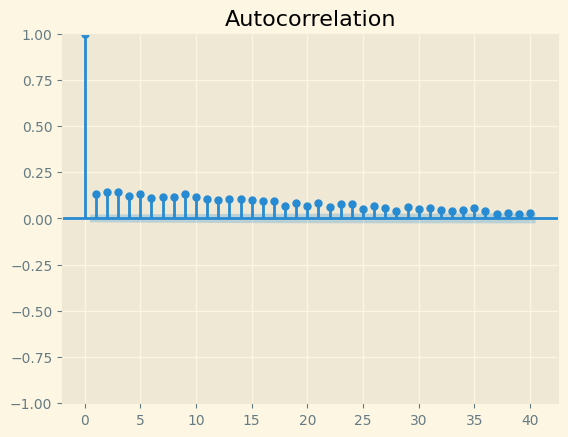

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf      #Importing Plotting Function


#Autocorrelation Plot
plot_acf(df_sin['pressure'],lags=40)
plt.show()

As per the above plot, we can say data is positively correlated up to lags 40.

Where the autocorrelation value itself is quite low, indicating that data does not have a strong autocorrelation properties.

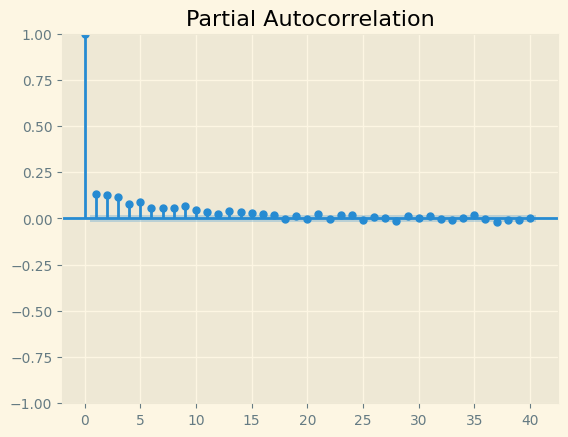

In [ ]:
#Partial Correlation Plot
plot_pacf(df_sin['pressure'],lags=40)
plt.show()

As per the above plot, we can say the correlation between two different points in time is also quite week, decaying to zero starting in the 15th Lags.



---



# Model Selection

**Preparing Data Input and Output**
We are using LSTM algorithm. For experimenting, we will be using training data of 1 month containing 2015-03-20 period where failure happened to predict another failure which occure at 2015-05-21 according to failure record.

The feature we are going to use is Pressure reading and Timestamp.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Selecting the date to check from failure records
st_train = df_sin.loc[df_sin['datetime']=="2015-03-20"].index.values[0]

#Filtering data to include approximately one month window
start_period = st_train-14*24
end_period = st_train+14*24

def create_feature(start,end):  #Creating Feature from selected machine
  pressure = df_sin.loc[start: end, 'pressure']
  timestamp = pd.to_datetime(df_sin.loc[start: end, 'datetime'])
  timestamp_hour = timestamp.map(lambda x: x.hour)
  timestamp_dow = timestamp.map(lambda x: x.dayofweek)

  #Applying one-hot encode for timestamp data
  timestamp_hour_onehot = pd.get_dummies(timestamp_hour).to_numpy()

  #Applying Min Max to numerical data
  scaler = MinMaxScaler()
  pressure = scaler.fit_transform(np.array(pressure).reshape(-1,1))

  #Combining Features Into One
  feature = np.concatenate([pressure, timestamp_hour_onehot],axis=1)
  X = feature[:-1]
  y = np.array(feature[5:,0]).reshape(-1,1)
  return X, y, scaler

X, y, pres_scaler = create_feature(start_period, end_period)


We need to shape the input further into a sequence i.e 3-dimensional numpy array. We will be using a function to return input and output sequence where each input sequence consist of 5-points observation.

How:- Putting Observation of **Past 5 Hours** will be used to predict the sensor reading for the **Next 1 Hour**

In [ ]:
def shape_sequence(arr, step, start):
  out = list()
  for i in range(start, arr.shape[0]):
    low_lim = i
    up_lim = low_lim + step
    out.append(arr[low_lim: up_lim])

    if up_lim == arr.shape[0]:
      break

  out_seq = np.array(out)
  return out_seq

#Shaping the sequence according to the length
X_seq = shape_sequence(X,5,0)
y_seq = shape_sequence(y,1,0)

#Seperating Input and Output for train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

print("Training Data Shape: ", X_train.shape)
print("Validating Data Shape: ", X_val.shape)

Training Data Shape:  (534, 5, 25)
Validating Data Shape:  (134, 5, 25)


In [ ]:

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# import SMOTE module from imblearn library
# pip install imblearn (if you don't have imblearn in your system)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train = np.nan_to_num(X_train)
X_train, y_train_c1 = sm.fit_resample(X_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))




---



#**Creating Prediction Model**

Creating a simple 2-layer LSTM moel with input shape matching the shape of the data sequence provided.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.losses as loss
from keras.metrics import MeanAbsoluteError


def create_model(X_train, y_train, X_val, y_val):   # Added validation data as inputs
    timesteps = X_train.shape[1]  # Number of timesteps
    features = X_train.shape[2]    # Number of features in each timestep
    lstm_units = 32  # Number of units in the LSTM layers

    model = Sequential()
    model.add(LSTM(lstm_units, activation='tanh', input_shape=(timesteps, features), return_sequences=True))
    model.add(LSTM(lstm_units, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(16, activation='tanh', return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # Adding 'accuracy' to the metrics list
    model.compile(optimizer=Adam(lr=0.035), loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

    # Providing validation data to model.fit
    model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=1000)

    return model

model = create_model(X_train, y_train, X_val, y_val)
model.summary()

Epoch 1/1000
17/17 [==============================] - 7s 60ms/step - loss: 0.1565 - mean_absolute_error: 0.3645 - val_loss: 0.0757 - val_mean_absolute_error: 0.2373
Epoch 2/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.0354 - mean_absolute_error: 0.1517 - val_loss: 0.0243 - val_mean_absolute_error: 0.1216
Epoch 3/1000
17/17 [==============================] - 0s 11ms/step - loss: 0.0223 - mean_absolute_error: 0.1175 - val_loss: 0.0229 - val_mean_absolute_error: 0.1159
Epoch 4/1000
17/17 [==============================] - 0s 11ms/step - loss: 0.0215 - mean_absolute_error: 0.1180 - val_loss: 0.0231 - val_mean_absolute_error: 0.1162
Epoch 5/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.0209 - mean_absolute_error: 0.1137 - val_loss: 0.0227 - val_mean_absolute_error: 0.1154
Epoch 6/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.0206 - mean_absolute_error: 0.1141 - val_loss: 0.0227 - val_mean_absolute_error: 0.1151
Epoch 7/10

#**Checking Validation Result**

Model's performance with vaildation data

5/5 [==============================] - 1s 4ms/step
Validation Error:  0.039469782


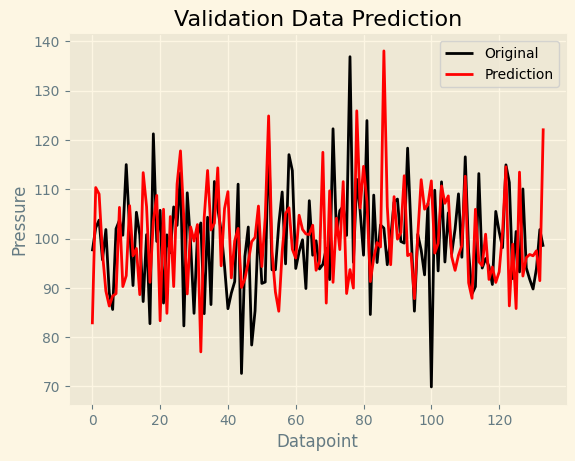

In [ ]:
#Checking through trained model
y_pred = model.predict(X_val)
mse = MeanSquaredError()
val_er = mse(y_val.reshape(-1,1),y_pred)
print("Validation Error: ", val_er.numpy())

#Using Inverse Transformation for better Observation
plt.plot(pres_scaler.inverse_transform(y_val.reshape(-1,1)),'k', label='Original')
plt.plot(pres_scaler.inverse_transform(y_pred.reshape(-1,1)),'r', label='Prediction')
plt.ylabel("Pressure")
plt.xlabel("Datapoint")
plt.title("Validation Data Prediction")
plt.legend()
plt.show()



---



#**Checking Testing Result**

From the above plot we can see some of the data points are innacurate, which can be caused by the highly fluctuating nature of hourly data points, so we are checking whether the model can predict the sensor reading correctly in the event of anamolies.

Picking up date where failure occured:- 2015-05-21

11/11 [==============================] - 0s 4ms/step
Testing Error =  0.049911488


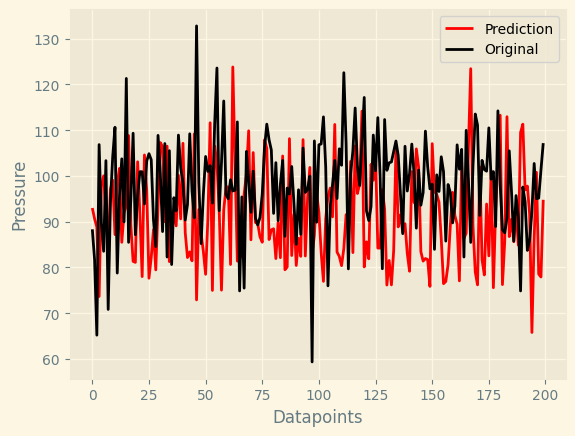

In [ ]:
#Date where another failure occured
st_test = df_sin.loc[df_sin['datetime']=="2015-05-21"].index.values[0]

#Filtering data to include approximately two-weeks window
start_period_test = st_test - 7*24
end_period_test = st_test + 7*24
X_test, y_test, test_scaler= create_feature(start_period_test, end_period_test)

#Shaping the sequence
X_test_seq = shape_sequence(X_test, 5, 0)
y_test_seq = shape_sequence(y_test, 1, 0)

#Predicting the testing data
y_pred_test = model.predict(X_test_seq)
test_er = mse(y_test_seq.reshape(-1,1), y_pred_test)
print("Testing Error = ", test_er.numpy())

#Selecting first 200 datapoints to allow for better plotting
#Returning the value using Inverse Transformation to allow better Observation
plt.plot(test_scaler.inverse_transform(y_pred_test[:200].reshape(-1,1)),'r', label="Prediction")
plt.plot(test_scaler.inverse_transform(y_test_seq[:200].reshape(-1,1)),'k', label="Original")
plt.ylabel("Pressure")
plt.xlabel("Datapoints")
plt.legend()
plt.show()

***We Observe that model can predict the sensor reading even in the event of machine failure, so we have to make sure the training data that we use to train should include past failure events as well***